# Choroid Plexus Segmentation Training via Auto3DSeg

In [7]:
import os
import json
import nibabel as nib
import nibabel as nibabel
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import glob
import random
from monai.apps.auto3dseg import AutoRunner
from monai.config import print_config
from monai_analysis.preproc import hemond_data, init_paths, prepare_scans
import importlib

print_config()

MONAI version: 1.3.2
Numpy version: 1.26.4
Pytorch version: 2.3.1+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 59a7211070538586369afd4a01eca0a7fe2e742e
MONAI __file__: /home/<username>/.virtualenvs/monai/lib/python3.12/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: 5.4.0
Nibabel version: 5.2.1
scikit-image version: 0.24.0
scipy version: 1.14.0
Pillow version: 10.4.0
Tensorboard version: 2.17.0
gdown version: 5.2.0
TorchVision version: 0.18.1+cu121
tqdm version: 4.66.4
lmdb version: 1.5.1
psutil version: 6.0.0
pandas version: 2.2.2
einops version: 0.8.0
transformers version: 4.42.4
mlflow version: 2.14.3
pynrrd version: 1.0.0
clearml version: 1.16.2

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [8]:
init_paths.main()
from monai_analysis.preproc.init_paths import DATA_HOME

importlib.reload(hemond_data)

<module 'monai_analysis.preproc.hemond_data' from '/home/srs-9/Dev/ms_mri/monai_analysis/preproc/hemond_data.py'>

## Prep the database

Get the data and labels organized

In [9]:
dataset = hemond_data.scan_data_dir(DATA_HOME)
dataset = hemond_data.assign_conditions(dataset)

No scan exists for subject: 1492 and session: 20190620


In [5]:
training_data = []
test_data = []

for scan in dataset:
    if scan.cond == 'tr':
        training_data.append({"image": scan.image, "label": scan.label})
    elif scan.cond == 'ts':
        test_data.append(scan.image)

## Review

In [11]:
def display_slices(scan):
    img1 = nibabel.load(scan.image)
    img2 = nibabel.load(scan.label)

    data1 = img1.get_fdata()[:,:,:]
    data2 = img2.get_fdata()

    slice_sums = np.sum(data2, axis=(0, 1))
    
    print(slice_sums)

    max_slice_index = np.argmax(slice_sums)
    print(f"Max slice: {max_slice_index}")

    slice1 = data1[:, :, max_slice_index]
    slice2 = data2[:, :, max_slice_index]    

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(slice1, cmap='gray')
    plt.title(f"Image 1 - Slice {max_slice_index}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(slice2, cmap='gray')
    plt.title(f"Image 2 - Slice {max_slice_index}")
    plt.axis('off')
    plt.show()


[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000

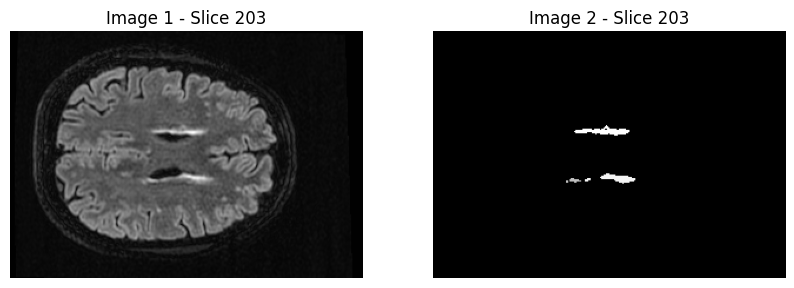

In [13]:
display_slices(dataset[0])

In the original code, they include labels in the test data as well. Also they have a function that checks that there is nonzero number of voxels in the label

In [23]:
#? I don't know why they put labels for the test data. the brats segmentation code didn't.
# train_data = [{'image': path + '/flair.nii.gz', 'label': path + '/flair_chp_mask_qced.nii.gz'} for path in train_exams]
# test_data = [{'image': path + '/flair.nii.gz', 'label': path + '/flair_chp_mask_qced.nii.gz'} for path in test_exams]

train_data = []
test_data = []
for scan in dataset:
    if scan.cond == 'tr' and scan.has_label:
        train_data.append({"image": str(scan.image), "label": str(scan.label)})
    elif scan.cond == 'ts' and scan.has_label():
        test_data.append({"image": str(scan.image), "label": str(scan.label)})


print(f"Train num total: {len(train_data)}")
print(f"Test num: {len(test_data)}")

Train num total: 321
Test num: 29


In [24]:
datalist = {
    "testing": test_data,
    "training": [{"fold": i % 5, "image": c["image"], "label": c["label"]} for i,c in enumerate(train_data)]
}

In [25]:
datalist

{'testing': [{'image': '/mnt/t/Data/MONAI/flair/sub-ms1024_ses-20170710.nii.gz',
   'label': '/mnt/t/Data/MONAI/flair/labels/sub-ms1024_ses-20170710.nii.gz'},
  {'image': '/mnt/t/Data/MONAI/flair/sub-ms1028_ses-20190608.nii.gz',
   'label': '/mnt/t/Data/MONAI/flair/labels/sub-ms1028_ses-20190608.nii.gz'},
  {'image': '/mnt/t/Data/MONAI/flair/sub-ms1054_ses-20161006.nii.gz',
   'label': '/mnt/t/Data/MONAI/flair/labels/sub-ms1054_ses-20161006.nii.gz'},
  {'image': '/mnt/t/Data/MONAI/flair/sub-ms1078_ses-20180412.nii.gz',
   'label': '/mnt/t/Data/MONAI/flair/labels/sub-ms1078_ses-20180412.nii.gz'},
  {'image': '/mnt/t/Data/MONAI/flair/sub-ms1083_ses-20180227.nii.gz',
   'label': '/mnt/t/Data/MONAI/flair/labels/sub-ms1083_ses-20180227.nii.gz'},
  {'image': '/mnt/t/Data/MONAI/flair/sub-ms1118_ses-20181217.nii.gz',
   'label': '/mnt/t/Data/MONAI/flair/labels/sub-ms1118_ses-20181217.nii.gz'},
  {'image': '/mnt/t/Data/MONAI/flair/sub-ms1122_ses-20170427.nii.gz',
   'label': '/mnt/t/Data/MONAI/

In [26]:
work_dir = "./cp_work_dir_20231215"
if not os.path.isdir(work_dir):
    os.makedirs(work_dir)

dataroot_dir = DATA_HOME
if not os.path.isdir(dataroot_dir):
    os.makedirs(dataroot_dir)

datalist_file = os.path.join(work_dir, "datalist.json")
with open(datalist_file, "w") as f:
    json.dump(datalist, f)

In [27]:
runner = AutoRunner(
    work_dir=work_dir,
    algos=["swinunetr"],
    input={
        "modality": "MRI",
        "datalist": datalist_file,
        "dataroot": dataroot_dir,
    },
)

2024-07-15 22:19:24,983 - INFO - AutoRunner using work directory /home/srs-9/Dev/ms_mri/monai_analysis/notebooks/cp_work_dir_20231215
2024-07-15 22:19:24,986 - INFO - Found num_fold 5 based on the input datalist /home/srs-9/Dev/ms_mri/monai_analysis/notebooks/cp_work_dir_20231215/datalist.json.
2024-07-15 22:19:24,987 - INFO - Setting num_fold 5 based on the input datalist /home/srs-9/Dev/ms_mri/monai_analysis/notebooks/cp_work_dir_20231215/datalist.json.
2024-07-15 22:19:24,988 - INFO - Using user defined command running prefix , will override other settings


In [28]:
max_epochs = 100

train_param = {
    "num_epochs_per_validation": 1,
    #"num_images_per_batch": 10,
    "num_epochs": max_epochs,
    "num_warmup_epochs": 1,
}
runner.set_training_params(train_param)

In [29]:
runner.run()

2024-07-15 22:19:43,130 - INFO - Running data analysis...
2024-07-15 22:19:43,131 - INFO - Found 1 GPUs for data analyzing!


100%|██████████| 321/321 [06:19<00:00,  1.18s/it]


2024-07-15 22:26:12,492 - INFO - Data spacing is not completely uniform. MONAI transforms may provide unexpected result
2024-07-15 22:26:12,493 - INFO - Writing data stats to /home/srs-9/Dev/ms_mri/monai_analysis/notebooks/cp_work_dir_20231215/datastats.yaml.
2024-07-15 22:26:12,698 - INFO - Writing by-case data stats to /home/srs-9/Dev/ms_mri/monai_analysis/notebooks/cp_work_dir_20231215/datastats_by_case.yaml, this may take a while.
2024-07-15 22:26:19,092 - INFO - BundleGen from https://github.com/Project-MONAI/research-contributions/releases/download/algo_templates/e4cf5a1.tar.gz


algo_templates.tar.gz: 104kB [00:00, 246kB/s]                              

2024-07-15 22:26:19,529 - INFO - Downloaded: /tmp/tmpvj4hhr0d/algo_templates.tar.gz
2024-07-15 22:26:19,530 - INFO - Expected md5 is None, skip md5 check for file /tmp/tmpvj4hhr0d/algo_templates.tar.gz.
2024-07-15 22:26:19,530 - INFO - Writing into directory: /home/srs-9/Dev/ms_mri/monai_analysis/notebooks/cp_work_dir_20231215.


2024-07-15 22:26:19,909 - INFO - Generated:/home/srs-9/Dev/ms_mri/monai_analysis/notebooks/cp_work_dir_20231215/swinunetr_0
2024-07-15 22:26:20,262 - INFO - Generated:/home/srs-9/Dev/ms_mri/monai_analysis/notebooks/cp_work_dir_20231215/swinunetr_1
2024-07-15 22:26:20,613 - INFO - Generated:/home/srs-9/Dev/ms_mri/monai_analysis/notebooks/cp_work_dir_20231215/swinunetr_2
2024-07-15 22:26:20,970 - INFO - Generated:/home/srs-9/Dev/ms_mri/monai_analysis/notebooks/cp_work_dir_20231215/swinunetr_3
2024-07-15 22:26:21,330 - INFO - Generated:/home/srs-9/Dev/ms_mri/monai_analysis/notebooks/cp_work_dir_20231215/swinunetr_4
2024-07-15 22:26:21,355 - INFO - ['python', '/home/srs-9/Dev/ms_mri/monai_analysis/notebooks/cp_work_dir_20231215/swinunetr_0/scripts/train.py', 'run', "--config_file='/home/srs-9/Dev/ms_mri/monai_analysis/notebooks/cp_work_dir_20231215/swinunetr_0/configs/hyper_parameters.yaml,/home/srs-9/Dev/ms_mri/monai_analysis/notebooks/cp_work_dir_20231215/swinunetr_0/configs/network.yaml

2024/07/15 22:26:54 INFO mlflow.tracking.fluent: Experiment with name 'Auto3DSeg' does not exist. Creating a new experiment.
swinunetr_0 - training ...:   4%|▍         | 4/100 [1:40:07<40:02:49, 1501.77s/round]
Traceback (most recent call last):
  File "/home/srs-9/Dev/ms_mri/monai_analysis/notebooks/cp_work_dir_20231215/swinunetr_0/scripts/train.py", line 850, in <module>
    fire.Fire()
  File "/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/fire/core.py", line 143, in Fire
    component_trace = _Fire(component, args, parsed_flag_args, context, name)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/fire/core.py", line 477, in _Fire
    component, remaining_args = _CallAndUpdateTrace(
                                ^^^^^^^^^^^^^^^^^^^^
  File "/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/fire/core.py", line 693, in _CallAndUpdateTrace
    component = fn(*varargs

CalledProcessError: Command '['python', '/home/srs-9/Dev/ms_mri/monai_analysis/notebooks/cp_work_dir_20231215/swinunetr_0/scripts/train.py', 'run', "--config_file='/home/srs-9/Dev/ms_mri/monai_analysis/notebooks/cp_work_dir_20231215/swinunetr_0/configs/hyper_parameters.yaml,/home/srs-9/Dev/ms_mri/monai_analysis/notebooks/cp_work_dir_20231215/swinunetr_0/configs/network.yaml,/home/srs-9/Dev/ms_mri/monai_analysis/notebooks/cp_work_dir_20231215/swinunetr_0/configs/transforms_infer.yaml,/home/srs-9/Dev/ms_mri/monai_analysis/notebooks/cp_work_dir_20231215/swinunetr_0/configs/transforms_train.yaml,/home/srs-9/Dev/ms_mri/monai_analysis/notebooks/cp_work_dir_20231215/swinunetr_0/configs/transforms_validate.yaml'", '--num_epochs_per_validation=1', '--num_epochs=100', '--num_warmup_epochs=1']' returned non-zero exit status 1.